# This Notebook illustrates how to analyse a Whatsapp group conversation and analyse sentiment

** How do we do this **
1. Retrieve conversation from a Whatsapp Group Chat as text file
2. Interpret structure of the conversations and build regular expressions to break down in to tokens
3. Parse content and build a Pandas dataframe to analyse
4. Invoke Google Natural Language API to analyse sentiments

** What Python features are used **
This notebook explores the following features of Python
+ Regular Expressions
+ Pandas Data Frames
+ Google Natural Language API

## 1. Retrieve a conversation from Whatsapp

+ Open a Whatsapp conversation
+ Open Menu (Top Right)
+ Expand More
+ Export Chat
+ Multiple options are available. Choose E-Mail to get the conversation extract as a mail attachment
+ Store in a local file as txt

## 2. Interpret converstation structure

A typical message could be as follows. The structure can vary based on phone settings

5/4/16, 4:44 PM - Vamsi Namburu: Good Morning

The string can be broken down in to **date**, **time**, **who** sent the message and **the** message
<chat_date>,<chat_time> - <chat_who>: <chat_what>

## 3.1 Parse Content

Create a Python Regular Expression to extract based on the pattern and delimiters

#### 3.1.1 Regular Expression for each message

In [1]:
import re
pattern_extract_all = re.compile(r'(?P<chat_date>\d{1,2}\/\d{1,2}\/\d{2,4}),\s(?P<chat_time>\d{1,2}:\d{1,2}\s[A|P]M)\s-\s(?P<chat_who>[^:]+):(?P<chat_what>.*)')

#### 3.1.2 Helper expression to check if the message starts with a date to distinguish between a new message and new line within a message

In [2]:
pattern_sw_date = re.compile(r'^(?P<chat_date>\d{1,2}\/\d{1,2}\/\d{2,4})')

In [3]:
# Import other standard libraries
import string
from datetime import datetime







In [4]:
#Open whatsapp conversation export
fhand = open('WHATSAPP_ANALYSIS.txt','r')

In [5]:
# Some variables to parse the whatsapp text
prev_mesg = ''
mesg_list = list()  # A List to hold each message
media_mesg = 'N'

#### 3.1.3 Loop through the lines,  gather tokens from the messages, build a message list

In [6]:
for line in fhand:
    if len(line.rstrip()) < 1 : continue  #Ignore empty lines
    #print len(line)    
    first_line_of_mesg = pattern_sw_date.search(line.rstrip())
    if first_line_of_mesg:
        if len(prev_mesg) > 0 :
            mesg_list.append((chat_date,chat_time,chat_who,prev_mesg,len(prev_mesg),media_mesg)) # Message is a tuple of all tokens
        prev_mesg = ''
        media_mesg ='N'
        read_all_patterns = pattern_extract_all.search(line.rstrip())
        if read_all_patterns:
            chat_date = read_all_patterns.group('chat_date')
            chat_time = read_all_patterns.group('chat_time')
            chat_who = read_all_patterns.group('chat_who')
            chat_what = read_all_patterns.group('chat_what')
            if chat_what.find('<Media omitted>') != -1 : media_mesg = 'Y'
            prev_mesg = chat_what
            #print chat_date,chat_time,chat_who,chat_what
    else:
        # Simply accumulate the line
        prev_mesg = prev_mesg+line
fhand.close()

#### 3.1.4 Examine a sample message

In [7]:
mesg_list[12]

('5/4/16',
 '4:44 PM',
 'Vamsi Namburu',
 ' I am also stuck and busy here.',
 31,
 'N')

### 3.2 Convert the list of tuples in to a dictionary with headers to convert into a DataFrame

Import few data science libraries

In [8]:
# Data Science Libraries for data analysis and plotting
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib notebook


#### 3.2.1 A function to convert a list to a dictionary

In [9]:

def convert_to_dict_list(mesg_list):
    refined_mesg_list = []
    for idx in range(len(mesg_list)):
        d = { 'when_day' : datetime.date(datetime.strptime(mesg_list[idx][0],'%m/%d/%y')), \
              'when_time': datetime.time(datetime.strptime(mesg_list[idx][1],'%I:%M %p')), \
              'who_sent' : mesg_list[idx][2], \
              'sent_what' : mesg_list[idx][3],\
              'how_much' : mesg_list[idx][4], \
              'sent_media' : mesg_list[idx][5]
            }
        refined_mesg_list.append(d)
    return refined_mesg_list

In [10]:
dct = convert_to_dict_list(mesg_list)

#### 3.2.2 Convert the dictionary into a pandas DataFrame

In [11]:
def convert_to_DF(mesg_dict):
    df = pd.DataFrame(mesg_dict)
    return df

In [12]:
df = convert_to_DF(dct)

#### 3.2.3 Analyse the DataFrame

In [13]:
df_counts = df.groupby('who_sent').agg({'sent_what':'count'})

In [14]:
#messages by each group member
df_counts

,sent_what
who_sent,
Harsha,674
Manoj US Mobil,265
Suman China,554
Vamsi Namburu,289
Yogeesh,1309
‪+91 99890 28742‬,7


#### 3.2.4 Histogram plot of message count by each group member

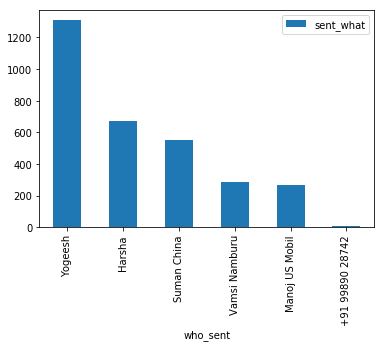

In [15]:
df_counts.sort_values(by='sent_what',ascending=False).plot(kind='bar')

#### 3.2.5 Cumulative sum of message length sent by each member

In [16]:
df_mesgs = df.groupby('who_sent').agg({'how_much':'sum'})
df_mesgs

,how_much
who_sent,
Harsha,45845
Manoj US Mobil,6934
Suman China,52879
Vamsi Namburu,12573
Yogeesh,280676
‪+91 99890 28742‬,118


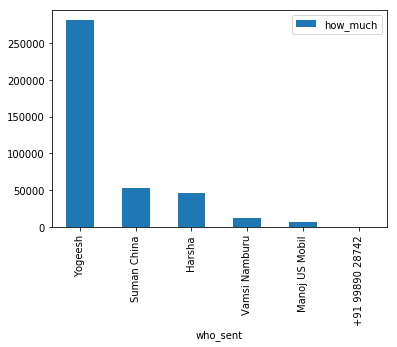

In [17]:
df_mesgs.sort_values(by='how_much',ascending=False).plot(kind='bar')

#### 3.2.6 Average Message Size

In [18]:
df_avg_mesg = df.groupby('who_sent').agg({'how_much':'mean'})
df_avg_mesg

,how_much
who_sent,
Harsha,68.019288
Manoj US Mobil,26.166038
Suman China,95.449458
Vamsi Namburu,43.505190
Yogeesh,214.420168
‪+91 99890 28742‬,16.857143


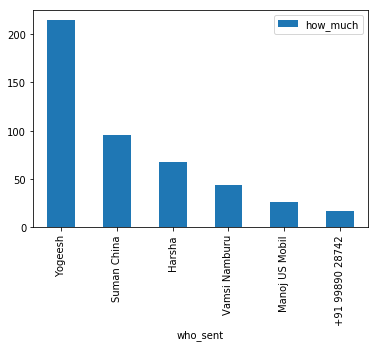

In [19]:
df_avg_mesg.sort_values(by='how_much',ascending=False).plot(kind='bar')


#### 3.2.7 Who shared maximum media

In [20]:
# Pass a boolean series to create another dataframe
media_mask = df['sent_media'] == 'Y'
df_media = df[media_mask].groupby('who_sent').agg({'sent_what':'count'}).sort_values(by='sent_what',ascending=False)
df_media

,sent_what
who_sent,
Yogeesh,535
Suman China,193
Harsha,139
Vamsi Namburu,41
‪+91 99890 28742‬,4


In [21]:
df_media.idxmax()['sent_what'] + " sent maxiumum number of messages : "+ str(df_media.max()['sent_what'])

'Yogeesh sent maxiumum number of messages : 535'

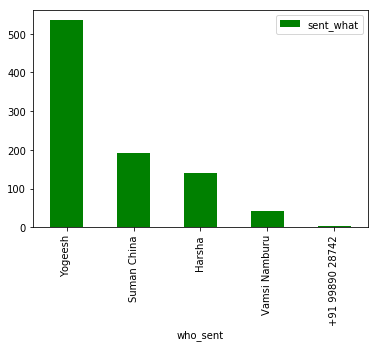

In [22]:
df_media.plot(kind='bar',colormap='ocean')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6c16875550>],
      dtype=object)

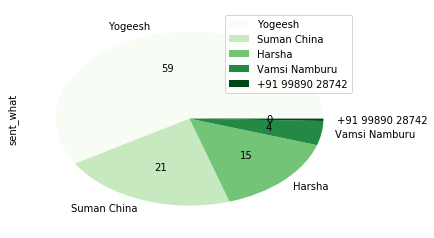

In [23]:
df_media.plot(subplots=True,kind='pie',autopct='%.0f',colormap='Greens')

#### 3.2.8 Who has sent the largest message and when

In [24]:
d = df.max()
print "On "+str(d['when_day'])+" at "+str(d['when_time'])+' '+d['who_sent']+' sent the largest message which is '+str(d['how_much'])

On 2018-02-15 at 23:59:00 ‪+91 99890 28742‬ sent the largest message which is 11377


#### 3.2.9 The day when the most number of messages were sent

In [25]:
d = df.groupby('when_day').agg({'sent_what':'count'})
x = "On "+str(d.idxmax()['sent_what'])+' a maximum of '+str(d.max()['sent_what'])+" messages were exchanged in the group"
x

'On 2016-12-25 a maximum of 128 messages were exchanged in the group'

#### 3.2.10 When were most number of media shared

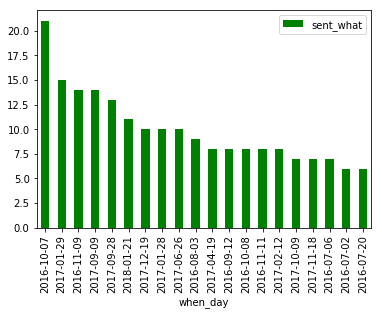

In [26]:
media_mask = df['sent_media'] == 'Y'
df_media = df[media_mask].groupby('when_day').agg({'sent_what':'count'}).sort_values(by='sent_what',ascending=False).head(20)
df_media.plot(kind='bar',colormap='ocean')

#### 3.2.11 Busiest Hour for the group

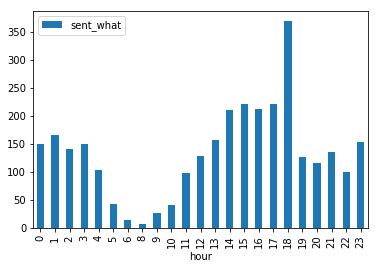

In [27]:
df['hour'] = df['when_time'].apply(lambda x : x.hour)
df.groupby('hour').agg({"sent_what":"count"}).plot(kind='bar')

##### Majority of the messages are sent at 18:00 roughly the logff time

### 4 Sentiment Analysis using Google Natural Language API

#### 4.1.1 Google API Setup

+ If using pip, install google-cloud-language 
+ If using Anaconda, install google-cloud-sdk & bioconda

#### 4.1.2 Setup of API Key and OS Parameter

+ Download API Key Json from Google account
+ Setup GOOGLE_LANGUAGE_CREDENTIALS environment variable to point to the json file
[Detailed instructions available here](https://cloud.google.com/natural-language/docs/reference/libraries#client-libraries-install-python)

In [28]:
# Google Natural Language API to analyse sentiments
from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types

In [29]:
client = language.LanguageServiceClient()

#### 4.2.1 Create a function to get sentiment for a text

In [30]:
def get_sentiment(mesg):
    try:
        
        document = types.Document(content=mesg,type=enums.Document.Type.PLAIN_TEXT)
        sentiment = client.analyze_sentiment(document=document).document_sentiment
        return round(sentiment.score,2)
    except:
        return 0
#exception used to avoid messages failing due to non-english messages and non-standard text

#### 4.2.2 Test a sample set of messages

In [31]:
get_sentiment('I am very disappointed')

-0.9

In [32]:
get_sentiment('Happiest moment of my life')

0.9

#### 4.3.1 Analyse sentiment for the month of Dec-2016

In [33]:
dt_dec_1_2016  = datetime.date(datetime(2016,12,1))
dt_dec_31_2016 = datetime.date(datetime(2016,12,31))
dec_mask = (df['when_day'] >= dt_dec_1_2016) & (df['when_day'] <= dt_dec_31_2016)
d = df[dec_mask]
d['sentiment'] = d['sent_what'].map(lambda x : get_sentiment(x))

/home/vamsi/.conda/envs/my_env27/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### 4.3.2 Messages with Positive Sentiment

In [34]:
d[d['sentiment'] > 0.5 ][6:10]

,how_much,sent_media,sent_what,when_day,when_time,who_sent,hour,sentiment
1160,8,N,Is good,2016-12-25,18:01:00,Suman China,18,0.7
1172,25,N,Dhruva is also very good,2016-12-25,18:04:00,Yogeesh,18,0.8
1188,23,N,Happy Christmas to all,2016-12-25,18:09:00,Suman China,18,0.8
1194,12,N,Enjoy Suman,2016-12-25,18:10:00,Harsha,18,0.8


#### 4.3.3 Messages with Negative Sentiment

In [35]:
d[d['sentiment'] < -0.2 ][6:8]

,how_much,sent_media,sent_what,when_day,when_time,who_sent,hour,sentiment
1217,22,N,"Yes, song is very bad",2016-12-25,18:15:00,Suman China,18,-0.7
1218,16,N,No one can humm,2016-12-25,18:15:00,Suman China,18,-0.4
